In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle


Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = True
save_folder = 'UC2_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB             = "Archive2018_2019_prod"
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL   = "Recette_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

Univers_Depth  = 3            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_client     = -1           # Nombre de clients à sélectionner. MAX = 148188. -1 --> ALL
client_tresh   = 20           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 20           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = False        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = False        # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 9           # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 50           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Analysis    = False         # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_CONSO+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_CONSO+"]", conn)
print(df)

conn.close()

   Consommateur.KEY
0                -1
1                 1
2                 2
3                 3
4                 4
5                 5
6                 6
7                 7
8                 8
9                 9


## Récupération des données correspondant aux clients

In [4]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM ['''       + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ENTETE  + '''.'''    + TABLE_CONSO   + '''.KEY] > 0 '''
if nbr_client != -1:
    sql_command +=  ''' AND [''' + TABLE_ENTETE  +'''.'''     + TABLE_CONSO   + '''.KEY] < '''  + str(nbr_client)

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Recette_entete_ticket.Consommateur.KEY] > 0 
Time Taken to load DB: ~192secondes
10836528


In [5]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_my_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 0s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_my_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [6]:
univers_correspondance = {}
deleted = set()
for item in df_my_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_my_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{428: 1, 429: 1, 3: 2, 4: 2, 5: 2, 8: 7, 28: 27, 32: 31, 39: 38, 40: 38, 42: 41, 43: 41, 44: 41, 46: 45, 47: 45, 48: 45, 49: 45, 50: 45, 462: 51, 475: 51, 62: 61, 63: 61, 71: 70, 72: 70, 73: 70, 89: 88, 90: 88, 91: 88, 93: 92, 456: 125, 463: 125, 464: 125, 465: 125, 466: 125, 467: 125, 468: 125, 130: 129, 137: 136, 139: 138, 140: 138, 181: 180, 182: 180, 183: 180, 184: 180, 185: 180, 186: 180, 187: 180, 469: 213, 476: 213, 216: 215, 218: 217, 225: 224, 227: 226, 457: 228, 458: 228, 459: 228, 470: 228, 477: 228, 471: 229, 472: 229, 245: 244, 246: 244, 247: 244, 248: 244, 249: 244, 250: 244, 251: 244, 252: 244, 253: 244, 254: 244, 255: 244, 256: 244, 281: 280, 282: 280, 283: 280, 454: 322, 473: 322, 461: 325, 474: 325, 487: 327, 488: 327, 345: 344, 347: 346, 349: 348, 350: 348, 351: 348, 352: 348, 353: 348, 354: 348, 356: 355, 357: 355, 358: 355, 359: 355, 360: 355, 361: 355, 363: 362, 364: 362, 390: 362, 391: 362, 393: 392, 394: 392, 395: 392, 396: 392, 397: 392, 398: 392, 399: 392, 400

In [7]:
start = time()
dict_client_univ = {}

for i in range(nbr_data):
    univ   = df_univers[TABLE_UNIVERS][i]
    client = df_univers[TABLE_CONSO][i]
    if univ == -1:
        continue
    
    if univ in deleted:
        univ = univers_correspondance[univ]
    
    if not client in dict_client_univ:
        dict_client_univ[client] = {}
        
    if not univ in dict_client_univ[client]:
        dict_client_univ[client][univ] = 0
    dict_client_univ[client][univ] += 1

to_remove = []
for k,v in dict_client_univ.items():
    if sum(v.values()) < client_tresh:
        to_remove.append(k)
    else:
        maxi = max(v.values())
        dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

for k in to_remove:
    del dict_client_univ[k]
        
    
clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                        data = dict_client_univ.values())
clients_data = clients_data.replace(float('NaN'), 0)
 
print(clients_data)

# environ 10s * nbr_client/10.000
print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

             305       129       392       322       229       299       148  \
92009   0.016129  0.451613  1.000000  0.016129  0.056452  0.104839  0.040323   
106     0.000000  0.000000  1.000000  0.000000  0.000000  0.821429  0.071429   
81231   0.000000  0.271429  0.742857  0.142857  0.414286  1.000000  0.000000   
80107   0.000000  0.086957  0.000000  0.043478  0.000000  0.217391  0.173913   
55622   0.000000  0.000000  0.571429  0.571429  0.857143  0.285714  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
147291  0.000000  0.000000  0.250000  0.000000  0.000000  0.000000  0.000000   
147671  0.000000  0.000000  0.000000  0.200000  0.000000  0.000000  0.000000   
147633  0.000000  0.000000  0.000000  0.285714  0.000000  0.000000  0.000000   
147439  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
87061   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             228       244       220  .

In [8]:
# Standard Normalization
def standard_normalization(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

# Min-Max Normalization
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

norm_clients_data = clients_data
if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
if MinMax_Norm:
    norm_clients_data = minmax_normalization(norm_clients_data)

for column in norm_clients_data:
    if sum(norm_clients_data[column]) < univers_tresh:
        norm_clients_data = norm_clients_data.drop(columns = column)

norm_clients_data = shuffle(norm_clients_data)        
print(norm_clients_data)

             305       129       392       322       229       299       148  \
94669   0.000000  0.166667  0.333333  0.000000  0.000000  1.000000  0.333333   
96563   0.000000  0.000000  0.184211  0.526316  0.000000  0.263158  0.000000   
140227  0.000000  0.250000  0.500000  0.250000  0.250000  0.000000  0.250000   
8804    0.461538  0.000000  0.000000  0.692308  0.000000  0.076923  0.000000   
11486   0.166667  0.000000  0.166667  0.000000  0.000000  1.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
142409  0.000000  0.000000  0.000000  0.250000  0.000000  1.000000  0.000000   
105810  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
9351    0.000000  0.000000  0.023810  0.333333  1.000000  0.190476  0.000000   
52901   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23905   0.000000  0.210526  0.263158  0.421053  0.052632  1.000000  0.000000   

             228       244       220  .

<Figure size 1080x432 with 0 Axes>

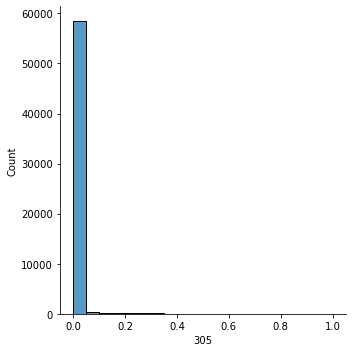

<Figure size 1080x432 with 0 Axes>

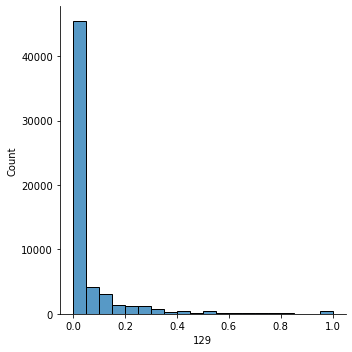

<Figure size 1080x432 with 0 Axes>

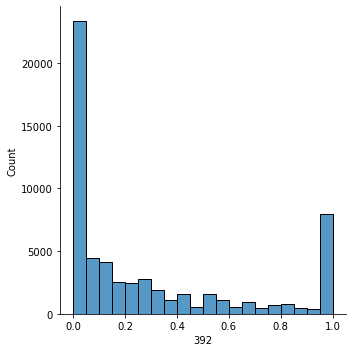

<Figure size 1080x432 with 0 Axes>

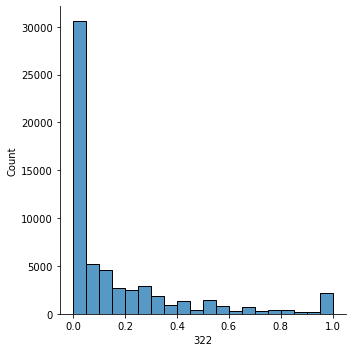

<Figure size 1080x432 with 0 Axes>

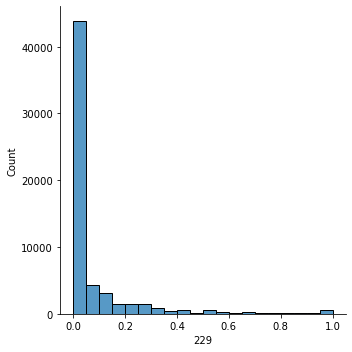

<Figure size 1080x432 with 0 Axes>

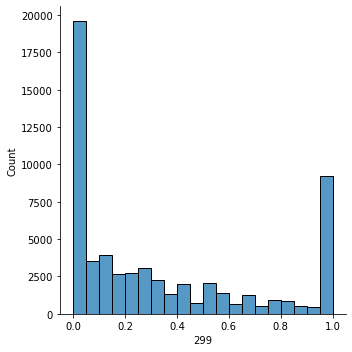

<Figure size 1080x432 with 0 Axes>

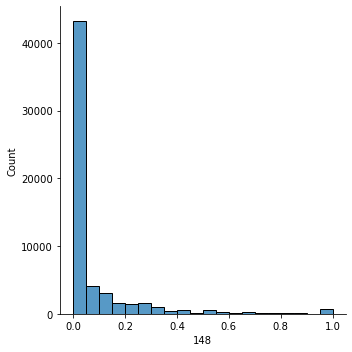

<Figure size 1080x432 with 0 Axes>

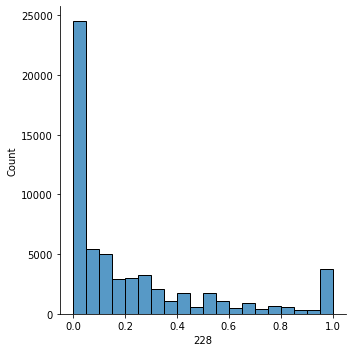

<Figure size 1080x432 with 0 Axes>

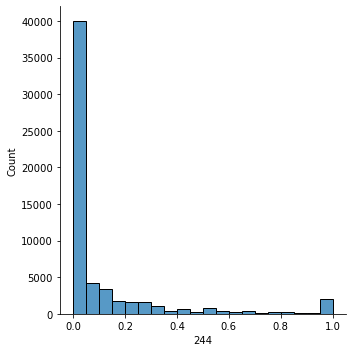

<Figure size 1080x432 with 0 Axes>

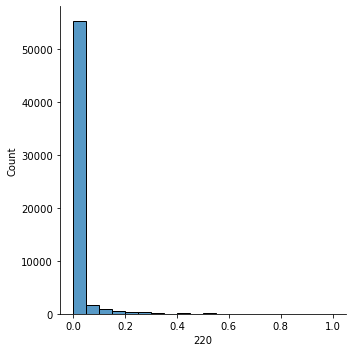

In [10]:
import seaborn as sns
for col in norm_clients_data.columns[:10]:
    plt.figure(1, figsize=(15,6))
    sns.displot(norm_clients_data[col], bins = 20)
    plt.show()

# SEGMENTATION DE LA CLIENTELE PAR KMEANS

In [ ]:
if do_Analysis:
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [ ]:
if do_Analysis:
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        cluster = model.predict(norm_clients_data)
        cluster_centers = model.cluster_centers_

        treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [ ]:
start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
cluster = model.labels_
# environ 1.5s * n_init
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [ ]:
cluster_centers = model.cluster_centers_

interest = {i:[] for i in range(len(cluster_centers))}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(cluster_centers)):
    for j in range(len(cluster_centers[i])):
        if cluster_centers[i][j] > treshold:
            interest[i].append(clients_data.columns[j])

In [ ]:
NACK = 0

conn = engine.connect()
for key,values in interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = cluster.tolist().count(key)*100/len(cluster)
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    print(df_libele.to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")

In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

# VISUALISATION PCA

In [ ]:
start = time()

target = cluster

model_pca = PCA(n_components= 2)

predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)

# environ 1.5s
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [ ]:
print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))

In [ ]:
plt.figure(figsize=(15, 7))  
plt.scatter(predict[:,0],predict[:,1], c=target, alpha=.8)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of dataset')

if save_fig:
    plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+".jpg")

In [ ]:
start = time()

target = cluster

model_pca = PCA(n_components= 3)
predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)
print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))


plt.figure(figsize=(30, 30)) 
ax = plt.axes(projection='3d')

ax.scatter3D(predict[:,0], predict[:,1], predict[:,2], c=target, cmap='Greens');

plt.title('PCA of dataset in 3D')

if save_fig:
    plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+"_3D.jpg")


print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

# SEGMENTATION HIERARCHICAL CLUSTERING

In [ ]:
if True:
    start = time()
    
    method = 'ward'  # ward weighted complete median average centroid single
    
    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(norm_clients_data.head(10000), method=method), p = 50, truncate_mode = 'level')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Dendogram_"+method+".jpg")
    plt.show()


    # Enivron 250s*(client/10000)²
    print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [ ]:
from sklearn.cluster import AgglomerativeClustering

start = time()

model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')  
model.fit_predict(norm_clients_data)
print(model)
# 15s * (N/10k)²
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [ ]:
temp10kmodel = model